# Trabalho Final - Redes Complexas¶

Código contendo o trabalho final desenvolvido na disciplina de Redes Complexas


In [16]:
# Importando as bibliotecas necessárias
import matplotlib.pyplot as plt
import numpy as np
from mplsoccer import Pitch, Sbopen
import pandas as pd
import networkx as nx
import seaborn as sns

In [28]:
# Instanciando um objeto parser para importar dados abertos da StatsBomb
parser = Sbopen()

# Extraindo os dados de competições disponíveis no StatsBomb em um DataFrame
df_competition = parser.competition()

# Verificando quais dessas competições são de futebol feminino
df_female_competitions = df_competition.loc[df_competition['competition_gender'] == "female"]

## 
# Extraindo os dados de todas as partidas da competição Women's World Cup - 2023
# competition_id = 72 e season_id = 107
## 
df_matches = parser.match(competition_id = 72, season_id = 107)

df_matches.to_csv("./Streamlit/matches.csv", index=False)

# Percorrendo o DataFrame de partidas
# for index, df_current_match in df_matches.iterrows():
#     print(df_current_match)
    # # Extraindo o nome e id do time da casa
    # match_home_team = df_current_match["home_team_name"]
    # match_home_team_id = df_current_match["home_team_id"]
    
    # # Extraindo o nome e id do time de fora
    # match_away_team = df_current_match["away_team_name"]
    # match_away_team_id = df_current_match["away_team_id"]
home_teams = df_matches["home_team_name"].unique()
home_teams

array(["Australia Women's", "Spain Women's", "Sweden Women's",
       "Brazil Women's", "Netherlands Women's", "Japan Women's",
       "Nigeria Women's", "Colombia Women's", "England Women's",
       "United States Women's", "France Women's", "Portugal Women's",
       "Switzerland Women's", "Costa Rica Women's", "Argentina Women's",
       "China PR Women's", "Canada Women's", "Philippines Women's",
       "New Zealand Women's", "Morocco Women's", "Korea Republic Women's",
       "Jamaica Women's", "South Africa Women's", "Panama Women's",
       "Vietnam Women's", "Haiti Women's", "Republic of Ireland Women's",
       "Norway Women's", "Germany Women's", "Italy Women's",
       "Denmark Women's", "Zambia Women's"], dtype=object)

In [7]:
# Extraindo o data frame contendo os dados da partida específica
df_current_match = df_matches.loc[df_matches['match_id'] == 3904629]



Australia Women's
1205
England Women's
865


In [8]:
# Extrai os eventos de uma partida fornecendo seu Id para o parser
df_events, related, freeze, tatics = parser.event(3904629)

### Extraindo os dados dos passes

In [9]:
# Procurando por eventos de substituição no jogo - (Time da Casa)
substitutions = df_events.loc[df_events["type_name"] == "Substitution"]
home_team_subs = substitutions.loc[substitutions["team_name"] == match_home_team]

# Extrai o índice do primeiro evento de substituição - (Time da Casa)
ht_first_sub_index = home_team_subs.iloc[0]["index"]

# Extraindo todos os eventos de passe da partida
match_passes = df_events.loc[df_events["type_name"] == "Pass"]
# Extraindo os eventos de passe - (Time da Casa)
home_team_passes = match_passes.loc[match_passes["team_name"] == match_home_team]

# Removendo eventos de Lateral
home_team_passes = home_team_passes.loc[match_passes.sub_type_name != "Throw-in"]

# Os passes bem sucedidos são aqueles nos quais o outcome_name é nulo
# Extraindo os passes bem sucedidos - (Time da Casa)
ht_succesful_passes = home_team_passes.loc[home_team_passes["outcome_name"].isnull()]

## 
# Os passes que aconteceram antes da primeira substituição têm id menor que o do evento de substituição. 
# Os ids dos eventos são sequenciais
## 
ht_first_sub_passes = ht_succesful_passes.loc[ht_succesful_passes["index"] < ht_first_sub_index]

## Extraindo os dados necessários para a rede de passes
# x: coordenada x de início do passe
# y: coordenada y de início do passe
# end_x: coordenada x de fim do passe
# end_y: coordenada y de fim do passe
# player_name: jogador que inicia o passe
# pass_recipient_name: jogador que recebe o passe
##
ht_first_sub_passes = ht_first_sub_passes[['x', 'y', 'end_x', 'end_y', "player_name", "pass_recipient_name"]]

# Formatando o nome das jogadoras para que apenas o sobrenome delas seja exibido
ht_first_sub_passes["player_name"] = ht_first_sub_passes["player_name"].apply(lambda x: str(x).split()[-1])
ht_first_sub_passes["pass_recipient_name"] = ht_first_sub_passes["pass_recipient_name"].apply(lambda x: str(x).split()[-1])

# Obs.: no exemplo do soccermatics um filtro é utilizado para simplificar o código, porém a extração dos dados foi feita passo
# a passo para melhor entendimento dos dados e como manipulá-los

### Calculando o tamanho e localização dos nós

In [10]:
# Criando um DataFrame vazio para armazenar as informações
df_scatter = pd.DataFrame()

# Percorre os eventos de cada jogador por nome
for i, name in enumerate(ht_first_sub_passes["player_name"].unique()):
    # Extrai as coordenadas x,y (início) do passe - Todos os passes que foram feitos pelo jogador, em que ele foi o passador
    # Os dados dos passes são convertidos para um array numpy
    passer_x = ht_first_sub_passes.loc[ht_first_sub_passes["player_name"] == name]["x"].to_numpy()
    passer_y = ht_first_sub_passes.loc[ht_first_sub_passes["player_name"] == name]["y"].to_numpy()

    # Extrai as coordenas end_x, end_y (fim) do passe - Todos os passes que foram recebidos pelo jogador, em que ele foi o receptor
    # Os dados dos passes são convertidos para um array numpy
    receiver_x = ht_first_sub_passes.loc[ht_first_sub_passes["pass_recipient_name"] == name]["end_x"].to_numpy()
    receiver_y = ht_first_sub_passes.loc[ht_first_sub_passes["pass_recipient_name"] == name]["end_y"].to_numpy()

    # Preenche no DataFrame o nome do jogador sendo analisado no momento
    df_scatter.at[i, "player_name"] = name

    # Calcula a média das coordenadas do jogador para determinar sua posição "média" no campo
    # Média da coordenada x do jogador no campo durante a partida, tanto como passador quanto receptor
    df_scatter.at[i, "x"] = np.mean(np.concatenate([passer_x, receiver_x]))
    # Média da coordenada y do jogador no campo durante a partida, tanto como passador quanto receptor
    df_scatter.at[i, "y"] = np.mean(np.concatenate([passer_y, receiver_y]))
    
    # Preenche no DataFrame a quantidade de passes do jogador sendo analisado no momento
    df_scatter.at[i, "no_passes"] = ht_first_sub_passes.loc[ht_first_sub_passes["player_name"] == name].count().iloc[0]

# Define o tamanho do marcador do vértice de acordo com a quantidade de passes feitos pelo jogador
df_scatter["marker_size"] = (df_scatter["no_passes"] / df_scatter["no_passes"].max() * 1500)

In [11]:
df_scatter

,player_name,x,y,no_passes,marker_size
0,Polkinghorne,41.655319,25.908511,25.0,1500.0
1,Hunt,40.965789,50.757895,24.0,1440.0
2,Gorry,61.513043,43.430435,24.0,1440.0
3,Carpenter,57.282000,68.680000,24.0,1440.0
4,Raso,77.031818,64.700000,8.0,480.0
5,Fowler,72.959259,32.100000,13.0,780.0
6,Kerr,76.853333,23.810000,9.0,540.0
7,Cooney-Cross,58.878125,27.128125,18.0,1080.0
8,Arnold,12.880952,41.942857,16.0,960.0
9,Catley,56.725926,11.448148,23.0,1380.0


### Calculando a espessura das arestas

In [12]:
# Calculando a quantidade de passes entre jogadores
df_lines = ht_first_sub_passes.groupby(["player_name", "pass_recipient_name"]).x.count().reset_index()
df_lines

,player_name,pass_recipient_name,x
0,Arnold,Carpenter,2
1,Arnold,Catley,3
2,Arnold,Cooney-Cross,1
3,Arnold,Foord,1
4,Arnold,Gorry,1
...,...,...,...
68,Polkinghorne,Hunt,3
69,Raso,Carpenter,4
70,Raso,Cooney-Cross,1
71,Raso,Fowler,2


In [13]:
# Renomeando a coluna para contagem de passes
df_lines.rename({"x": "pass_count"}, axis="columns", inplace=True)

# Definindo um limiar para quantidade de passes entre jogadores
# Nesse caso o limiar está definido a 0, de modo que todos os passes entre jogadores serão considerados
# É possível avaliar diferentes limiares para quantidade de passes
df_lines = df_lines[df_lines["pass_count"]>0]

In [14]:
df_lines

,player_name,pass_recipient_name,pass_count
0,Arnold,Carpenter,2
1,Arnold,Catley,3
2,Arnold,Cooney-Cross,1
3,Arnold,Foord,1
4,Arnold,Gorry,1
...,...,...,...
68,Polkinghorne,Hunt,3
69,Raso,Carpenter,4
70,Raso,Cooney-Cross,1
71,Raso,Fowler,2


### Plotando os nós

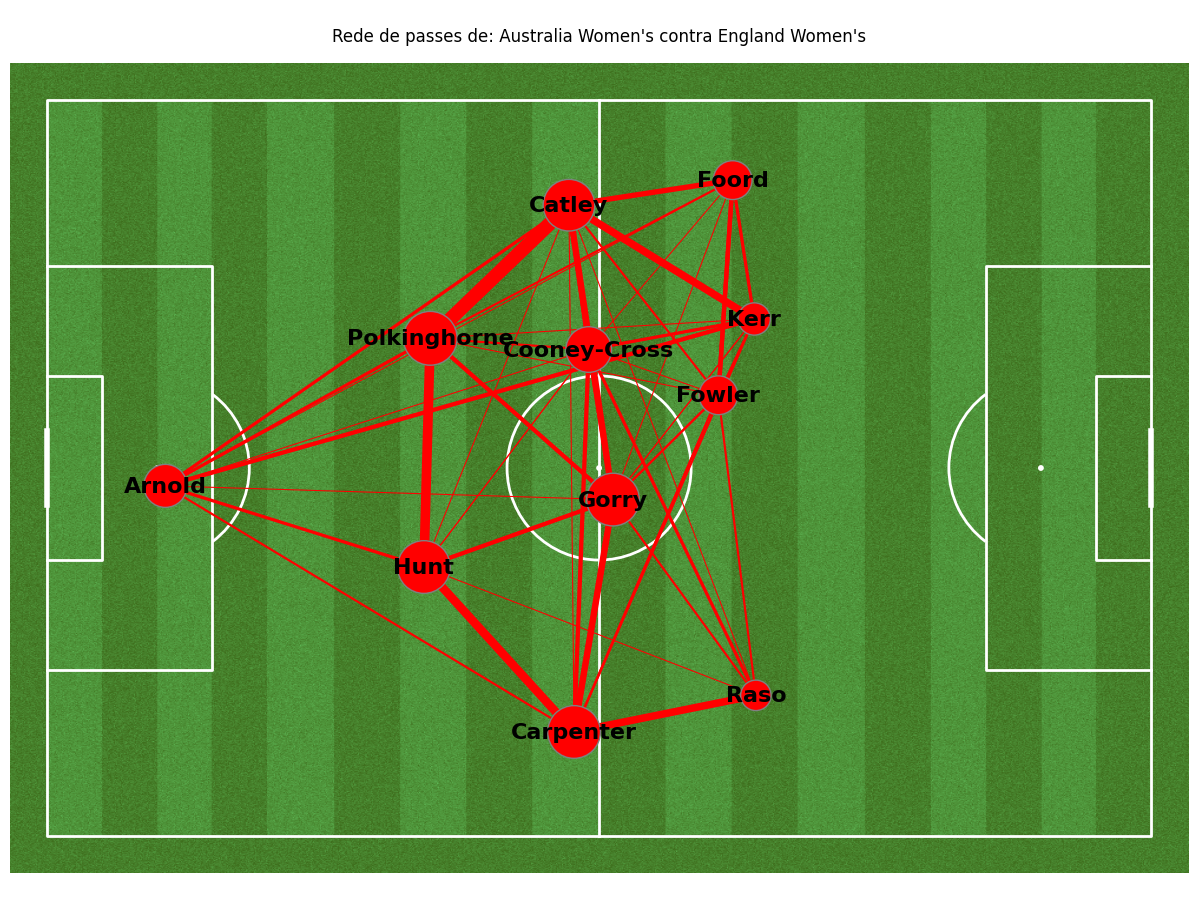

In [15]:
# Instanciando um campo - Verde com linhas brancas
pitch = Pitch(pitch_color='grass', line_color='white', stripe=True)
# Especificações da figura para plotagem
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)

# Dados de espalhamento dos jogadores no campo
pitch.scatter(
    df_scatter.x, 
    df_scatter.y, 
    s=df_scatter.marker_size,
    color="red",
    edgecolors="grey",
    linewidth=1, 
    alpha=1, 
    ax=ax["pitch"], 
    zorder = 3
)

# Anota os nomes dos jogadores nos nós, assim como suas coordenadas no campo
for i, row in df_scatter.iterrows():
    pitch.annotate(
        row.player_name, 
        xy=(row.x, row.y), 
        c='black', 
        va='center', 
        ha='center', 
        weight = "bold", 
        size=16, 
        ax=ax["pitch"], 
        zorder = 4
    )

# Percorre a rede de passes para cada par de jogadores
for i, row in df_lines.iterrows():
        # Extrai os jogadores
        player1 = row["player_name"]
        player2 = row["pass_recipient_name"]
    
        # Exrai as coordenadas x, y do primeiro jogador
        player1_x = df_scatter.loc[df_scatter["player_name"] == player1]['x'].iloc[0]
        player1_y = df_scatter.loc[df_scatter["player_name"] == player1]['y'].iloc[0]
        
        # Exrai as coordenadas x, y do segundo jogador
        player2_x = df_scatter.loc[df_scatter["player_name"] == player2]['x'].iloc[0]
        player2_y = df_scatter.loc[df_scatter["player_name"] == player2]['y'].iloc[0]

        # Extrai a quantidade de passes trocados pelos jogadores
        num_passes = row["pass_count"]
    
        # Ajusta a espessura da linha do link, quanto mais passes feitos maior será a espessura da linha
        line_width = (num_passes / df_lines['pass_count'].max() * 10)
    
        # Configuração do plot dos links
        pitch.lines(
            player1_x, 
            player1_y, 
            player2_x, 
            player2_y,
            alpha=1, 
            lw=line_width, 
            zorder=2, 
            color="red", 
            ax = ax["pitch"]
        )

# Título da partida com time da casa vs. time de fora
subtitle = "Rede de passes de: " + match_home_team + " contra " + match_away_team

# Determinando o título da partida
fig.suptitle(subtitle)

# Mostrando o campo com os jogadores plotados
plt.show()

### Centralização

-> Colocar a fórmula da centralização. Adicionar explicação sobre como funciona a centralização

Para calcular a centralização é preciso calcular o número de passes feitos por cada jogador.

In [16]:
# Calculando o número de passes para cada jogador
number_of_passes = ht_first_sub_passes.groupby(["player_name"]).x.count().reset_index()
number_of_passes.rename({'x': 'pass_count'}, axis='columns', inplace=True)

# Encontrando o jogador com maior número de passes
max_number_of_passes = number_of_passes["pass_count"].max()

# Realizando o cálculo da equação de centralização
# Calculando o denominador
denominator = 10*number_of_passes["pass_count"].sum()
# Calculando o numerador
nominator = (max_number_of_passes - number_of_passes["pass_count"]).sum()

# Calculando o índice de centralização
centralisation_index = nominator/denominator

print("O ídice de centralização do time " + match_home_team + " foi de: %.2f'" %centralisation_index)

O ídice de centralização do time Australia Women's foi de: 0.04'


Uma possibilidade de análise é utilizar apenas os passes para frente - ou seja - aqueles que fazem o jogo "avançar".
Alguns passes são apenas trocas entre jogadoras de um mesmo time para manter a posse.

### Calculando métricas de centralidade dos jogadores
Para o cálculo das medidas não é levado em consideração a posição média dos jogadores, apenas a troca de passes entre é interessante.

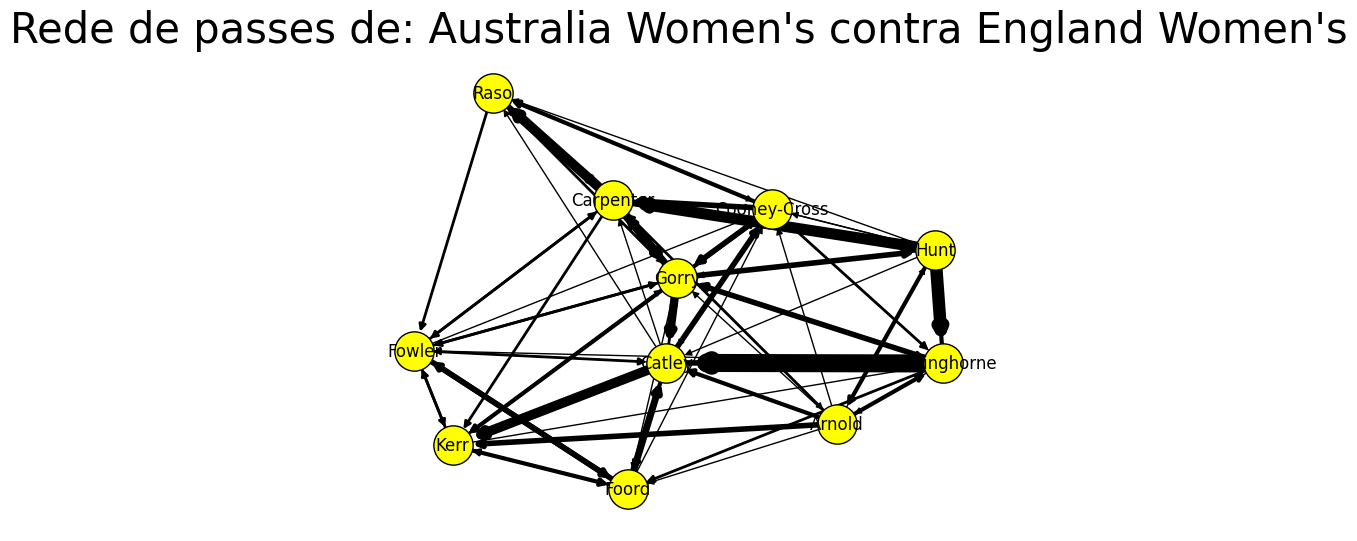

In [17]:
# O DataFrame de passes entre jogadores é convertido para o formato tupla para ser utilizado como grafo do networkx
pass_graph = df_lines.apply(tuple, axis=1).tolist()

# Criando um grafo isomorfo ao grafo de passes
AUS_Graph = nx.DiGraph()

# Percorrendo a lista de tuplas do grafo de passes
for i in range(len(pass_graph)):
    # Criando as arestas entre os nós (passes entre jogadores)
    # pass_graph[i][0]: representa o jogador que originou o passe
    # pass_graph[i][1]: representa o jogador que recebeu o passe
    # pass_graph[i][2]: representa a quantidade de passes entre a dupla de jogadores
    AUS_Graph.add_edge(pass_graph[i][0], pass_graph[i][1], weight=pass_graph[i][2])

# Extraindo as arestas do grafo criado
AUS_edges = AUS_Graph.edges()
# Extraindo os pesos para determinar a espessura das arestas
AUS_weights = [AUS_Graph[u][v]['weight'] for u, v in AUS_edges]

# Plotando o grafo isomorfo gerado
nx.draw(AUS_Graph, node_size=800, with_labels= True, node_color='yellow', width=AUS_weights)
# Colocando borda nos nós
plt.gca().collections[0].set_edgecolor('black')
# Definindo o título do plot
plt.title("Rede de passes de: " + match_home_team + " contra " + match_away_team, size=30)
plt.show()


#### Grau dos nós - Total

O grau de um nó representa quantos passes a jogadora esteve envolvida. Em um grafo direcionado o grau de um nó consiste na soma dos graus de entrada e saída, ou seja, a soma dos passes que foram originados e os passes que foram recebidos pelo jogador.

A partir do grau de entrada é possível calcular qual jogador recebeu mais passes e a partir do grau de saída é possível calcular qual jogador originou mais passes. 

C:\Users\julia\AppData\Local\Temp\ipykernel_2852\1533624309.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=Y, y=X, palette="magma", legend=False)


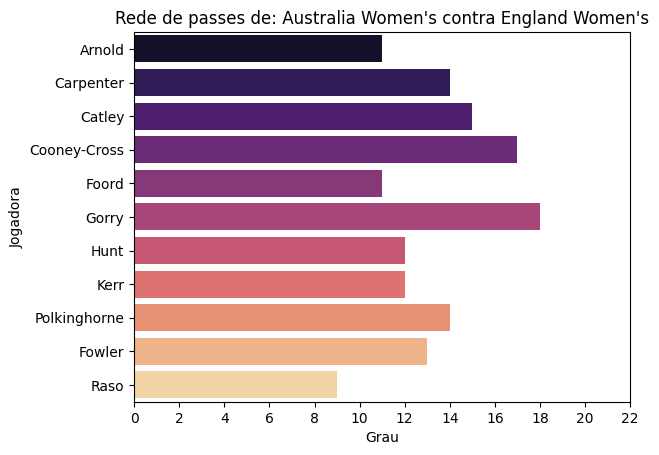

In [18]:
# Preparando um dicionário com o nome das jogadoras
degrees_AUS = dict(nx.degree(AUS_Graph))

# Criando um DataFrame a partir do dicionário de graus das jogadoras
df_degrees_AUS = pd.DataFrame.from_dict(list(degrees_AUS.items()))

# Renomeando as colunas para melhor entendimento
df_degrees_AUS.rename(columns = {
    0: "Nome da Jogadora",
    1: "Grau do Nó"
    },
    inplace=True
)     

# Plotando o grau de passes para cada jogadora
# Extraindo os atributos para plot
X = list(degrees_AUS.keys())
Y = list(degrees_AUS.values())

sns.barplot(x=Y, y=X, palette="magma", legend=False)

plt.xticks(range(0, max(Y)+5, 2))
plt.xlabel("Grau")
plt.ylabel("Jogadora")
plt.title("Rede de passes de: " + match_home_team + " contra " + match_away_team)

plt.show()

#### Grau dos nós - Entrada

C:\Users\julia\AppData\Local\Temp\ipykernel_2852\2833046692.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=Y, y=X, palette="magma", legend=False)


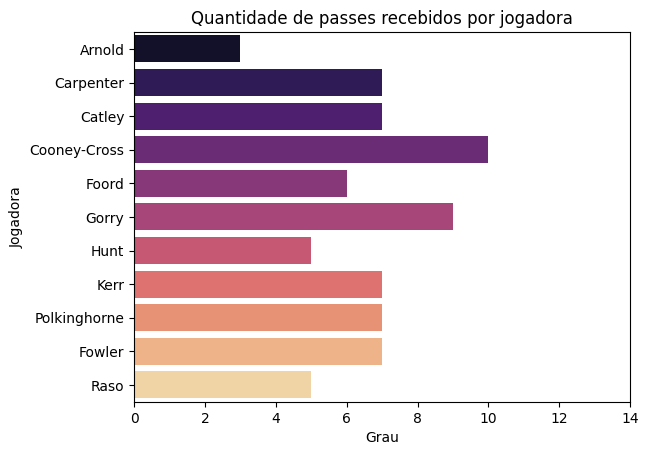

In [19]:
# Preparando um dicionário com o nome das jogadoras
degrees_AUS = dict(AUS_Graph.in_degree())

# Criando um DataFrame a partir do dicionário de graus das jogadoras
df_degrees_AUS = pd.DataFrame.from_dict(list(degrees_AUS.items()))

# Renomeando as colunas para melhor entendimento
df_degrees_AUS.rename(columns = {
    0: "Nome da Jogadora",
    1: "Grau do Nó"
    },
    inplace=True
)     

# Plotando o grau de passes para cada jogadora
# Extraindo os atributos para plot
X = list(degrees_AUS.keys())
Y = list(degrees_AUS.values())

sns.barplot(x=Y, y=X, palette="magma", legend=False)

plt.xticks(range(0, max(Y)+5, 2))
plt.xlabel("Grau")
plt.ylabel("Jogadora")
plt.title("Quantidade de passes recebidos por jogadora")

plt.show()

C:\Users\julia\AppData\Local\Temp\ipykernel_2852\3979010964.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=Y, y=X, palette="magma", legend=False)


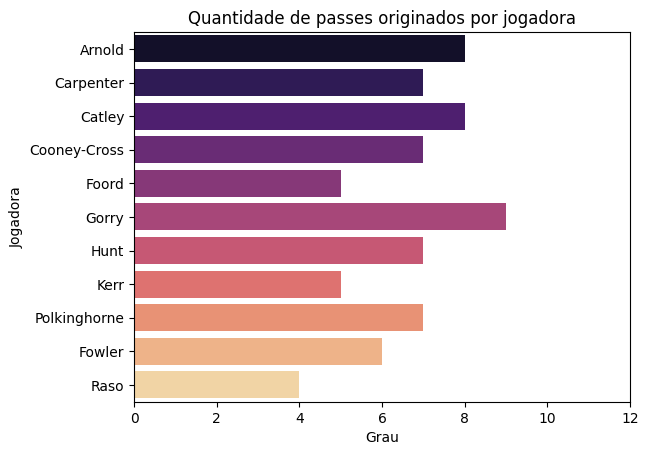

In [20]:
# Preparando um dicionário com o nome das jogadoras
degrees_AUS = dict(AUS_Graph.out_degree())

# Criando um DataFrame a partir do dicionário de graus das jogadoras
df_degrees_AUS = pd.DataFrame.from_dict(list(degrees_AUS.items()))

# Renomeando as colunas para melhor entendimento
df_degrees_AUS.rename(columns = {
    0: "Nome da Jogadora",
    1: "Grau do Nó"
    },
    inplace=True
)     

# Plotando o grau de passes para cada jogadora
# Extraindo os atributos para plot
X = list(degrees_AUS.keys())
Y = list(degrees_AUS.values())

sns.barplot(x=Y, y=X, palette="magma", legend=False)

plt.xticks(range(0, max(Y)+5, 2))
plt.xlabel("Grau")
plt.ylabel("Jogadora")
plt.title("Quantidade de passes originados por jogadora")

plt.show()

#### Excentricidade

Eccentricity of node i: highest distance from i to any other node.

Nesse caso, demonstra o quanto o jogador mais longe do jogador atual está na rede

In [24]:
# Calculando a excentricidade das jogadoras
excentricity_AUS = nx.eccentricity(AUS_Graph, v=None, weight='weight')
excentricity_AUS

{'Arnold': 3,
 'Carpenter': 3,
 'Catley': 4,
 'Cooney-Cross': 3,
 'Foord': 3,
 'Gorry': 3,
 'Hunt': 3,
 'Kerr': 4,
 'Polkinghorne': 3,
 'Fowler': 3,
 'Raso': 4}

In [27]:
avg_excentricity_AUS = sum(list(excentricity_AUS.values()))/len(excentricity_AUS)
print("Excentricidade média do time: " + str(avg_excentricity_AUS))

Excentricidade média do time: 3.272727272727273


#### Clustering do Nó e Grafo

O clustering médio varia de [0, 1], sendo 0 equivalente à sitaução em que nenhum dos nós da rede está conectado com os demais e 1 equivalente à situação em que o grafo é um clique, ou seja, todos os nós estão conectados entre si. Um coeficiente de clustering maior denota uma maior interação, troca de passes, entre os jogadores do time.

In [30]:
clustering_AUS = nx.clustering(AUS_Graph, weight='weight')
clustering_AUS

{'Arnold': 0.10871918038946478,
 'Carpenter': 0.12684887940822767,
 'Catley': 0.13598221870674285,
 'Cooney-Cross': 0.09521952602020041,
 'Foord': 0.13128888381047907,
 'Gorry': 0.11160704231827735,
 'Hunt': 0.13869129680669282,
 'Kerr': 0.12453360803289398,
 'Polkinghorne': 0.1265874443595596,
 'Fowler': 0.11093418206598539,
 'Raso': 0.151519561267708}

In [31]:
avg_clustering_AUS = nx.average_clustering(AUS_Graph, weight='weight')
avg_clustering_AUS

0.12381198392602108

#### Betweenness

"Denota qual jogador foi o mais importante"

In [33]:
betweenness_AUS = nx.betweenness_centrality(AUS_Graph, weight='weight')
betweenness_AUS

{'Arnold': 0.08505291005291006,
 'Carpenter': 0.05275132275132275,
 'Catley': 0.13185185185185183,
 'Cooney-Cross': 0.2540476190476191,
 'Foord': 0.03595238095238095,
 'Gorry': 0.16513227513227513,
 'Hunt': 0.08055555555555555,
 'Kerr': 0.03132275132275133,
 'Polkinghorne': 0.08944444444444444,
 'Fowler': 0.023809523809523808,
 'Raso': 0.020767195767195767}

#### Closeness

Determina o grau de proximidade da jogadora com a rede, demonstrando sua capacidade de conectar com o restante das jogadoras.

In [35]:
closeness_AUS = nx.closeness_centrality(AUS_Graph)
closeness_AUS

{'Arnold': 0.5882352941176471,
 'Carpenter': 0.7692307692307693,
 'Catley': 0.7692307692307693,
 'Cooney-Cross': 1.0,
 'Foord': 0.7142857142857143,
 'Gorry': 0.9090909090909091,
 'Hunt': 0.6666666666666666,
 'Kerr': 0.7692307692307693,
 'Polkinghorne': 0.7692307692307693,
 'Fowler': 0.7692307692307693,
 'Raso': 0.6666666666666666}